<a href="https://colab.research.google.com/github/pjcroxas/Transportation-Data-Science/blob/main/Spatial_Modeling_of_Taxi_GPS_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Global Positioning System (GPS) data has become a valuable source of information in mobility planning, transportation, and logistics in recent years. With the increasing use of GPS-enabled devices, vast amounts of location data are being generated every day. This data can be harnessed through data science techniques to gain insights into mobility patterns, such as the frequency and duration of trips, the most commonly used routes, and the modes of transportation used. This information can be used to improve transportation systems, optimize logistics operations, and enhance mobility planning. By analyzing GPS data, decision-makers can make more informed decisions to improve transportation efficiency, reduce congestion, and improve accessibility for all.

This data is provided by LTFRB and DOSTs Mobile Big Data Project. It is pre-cleaned and has separate notebook to showcase the process.

In [2]:
# INSTALL NECESSARY LIBRARIES
# !pip install matplotlib
# !apt install libproj-dev libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/v1.2.0rel.tar.gz
# !pip install pyproj==1.9.6

In [37]:
import math
import time, re
import datetime
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import cufflinks as cf
from plotly.offline import init_notebook_mode
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import DBSCAN
from google.colab import drive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
drive.mount('/content/gdrive')

%matplotlib inline
sns.set_style("white")
sns.set()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=False)
cf.go_offline()

In [4]:
gps_df = pd.read_csv('/content/gdrive/My Drive/Data Science Portfolio/Mobility Analysis/taxi_gps_data.csv', sep=',', encoding = 'latin-1')
gps_df = gps_df.drop(['Unnamed: 0'], axis=1)
gps_df = gps_df[["id", "time", "date", "lat", "lon", "year", "month", "day","hour", "minute", "second"]]

In [5]:
# Check data types
gps_df.dtypes

id         object
time       object
date       object
lat       float64
lon       float64
year        int64
month       int64
day         int64
hour        int64
minute      int64
second      int64
dtype: object

In [6]:
# format datetime column
gps_df["datetime"] = gps_df["date"] + " "+gps_df['time']
gps_df["datetime"] = gps_df['datetime'].str.replace(r'0 days ', '')
gps_df["datetime"] = pd.to_datetime(gps_df["datetime"], format='%Y-%m-%d %H:%M:%S.%f')
gps_df.head()

id                       time        date        lat        lon  year  \
0  ko-b314  0 days 09:48:41.000000000  2018-03-08  14.588641  121.18521  2018   
1  ko-b314  0 days 09:50:41.000000000  2018-03-08  14.588641  121.18521  2018   
2  ko-b314  0 days 09:52:41.000000000  2018-03-08  14.588641  121.18521  2018   
3  ko-b314  0 days 09:54:41.000000000  2018-03-08  14.588641  121.18521  2018   
4  ko-b314  0 days 09:56:41.000000000  2018-03-08  14.588641  121.18521  2018   

   month  day  hour  minute  second            datetime  
0      3    8     9      48      41 2018-03-08 09:48:41  
1      3    8     9      50      41 2018-03-08 09:50:41  
2      3    8     9      52      41 2018-03-08 09:52:41  
3      3    8     9      54      41 2018-03-08 09:54:41  
4      3    8     9      56      41 2018-03-08 09:56:41

In [7]:
gps_df["weekday"] = gps_df["datetime"].dt.day_name()
gps_df.head()

id                       time        date        lat        lon  year  \
0  ko-b314  0 days 09:48:41.000000000  2018-03-08  14.588641  121.18521  2018   
1  ko-b314  0 days 09:50:41.000000000  2018-03-08  14.588641  121.18521  2018   
2  ko-b314  0 days 09:52:41.000000000  2018-03-08  14.588641  121.18521  2018   
3  ko-b314  0 days 09:54:41.000000000  2018-03-08  14.588641  121.18521  2018   
4  ko-b314  0 days 09:56:41.000000000  2018-03-08  14.588641  121.18521  2018   

   month  day  hour  minute  second            datetime   weekday  
0      3    8     9      48      41 2018-03-08 09:48:41  Thursday  
1      3    8     9      50      41 2018-03-08 09:50:41  Thursday  
2      3    8     9      52      41 2018-03-08 09:52:41  Thursday  
3      3    8     9      54      41 2018-03-08 09:54:41  Thursday  
4      3    8     9      56      41 2018-03-08 09:56:41  Thursday

# **Temporal Coverage**

year
2018    217783
2019    110824
Name: count, dtype: int64


<Axes: ylabel='count'>

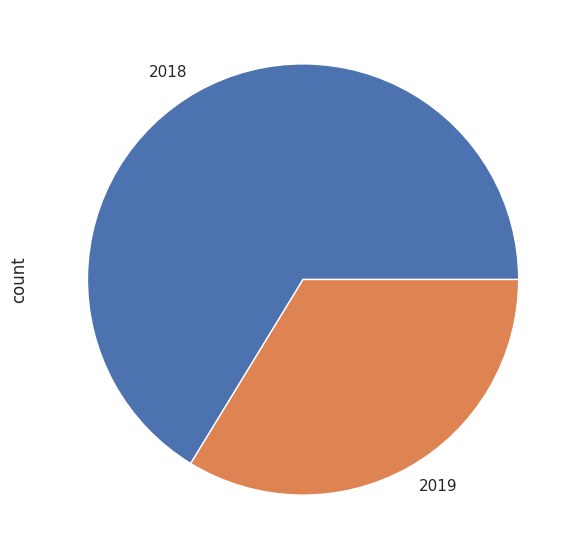

In [8]:
# Check GPS logs per year
print(gps_df["year"].value_counts())
gps_df["year"].value_counts().plot(kind="pie", figsize=(7,7))

In [9]:
# To simplify the analysis we will select the GPS logs of 2018.
gps_df_2018 = gps_df[gps_df["year"] == 2018]
gps_df_2019 = gps_df[gps_df["year"] == 2019]
gps_count_2018 = gps_df_2018["id"].value_counts().reset_index()
gps_count_2019 = gps_df_2019["id"].value_counts().reset_index()
gps_day_count_2018 = gps_df_2018["weekday"].value_counts().reset_index()

In [10]:
gps_day_count_2018

weekday  count
0     Monday  39887
1     Sunday  35474
2   Saturday  30206
3     Friday  29013
4    Tuesday  28520
5   Thursday  27633
6  Wednesday  27050

Text(0.5, 1.0, 'Estimated GPS logs per Day (2018)')

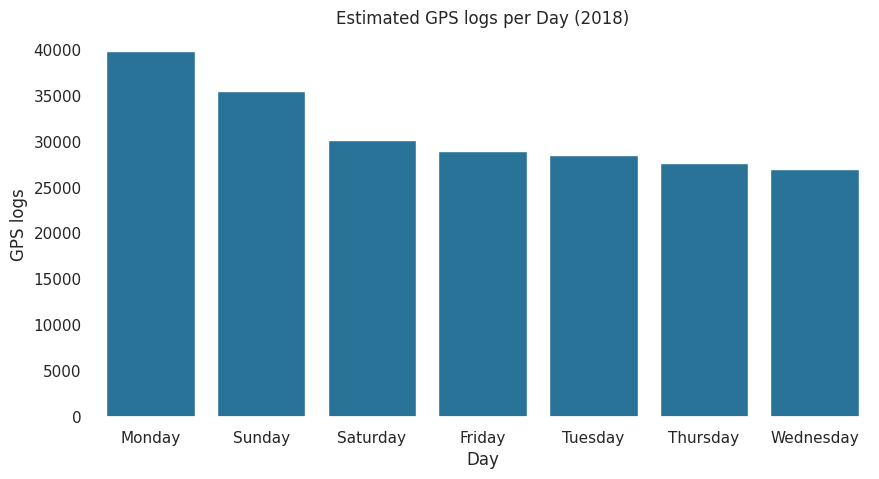

In [11]:
plt.figure(figsize=(10, 5))
fig = sns.barplot(data=gps_day_count_2018,
            y="count",
            x="weekday",
            color="#1679AB")
fig.set_facecolor('white')
plt.xlabel("Day")
plt.ylabel("GPS logs")
plt.title("Estimated GPS logs per Day (2018)")

Text(0.5, 1.0, 'Estimated GPS logs per user (2018)')

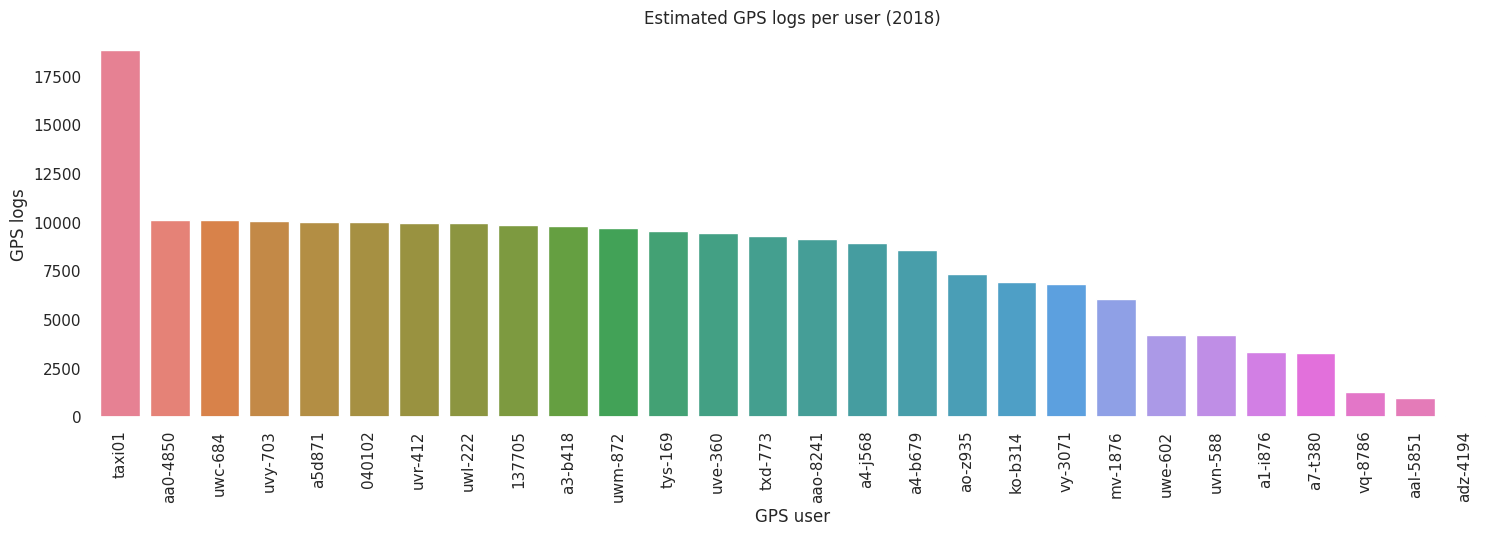

In [12]:
plt.figure(figsize=(18, 5))
fig = sns.barplot(data=gps_count_2018,
            y="count",
            x="id",
            hue="id")
fig.set_facecolor('white')
plt.xlabel("GPS user")
plt.ylabel("GPS logs")
plt.xticks(rotation=90)
plt.title("Estimated GPS logs per user (2018)")

Text(0.5, 1.0, 'Estimated GPS logs per user (2018)')

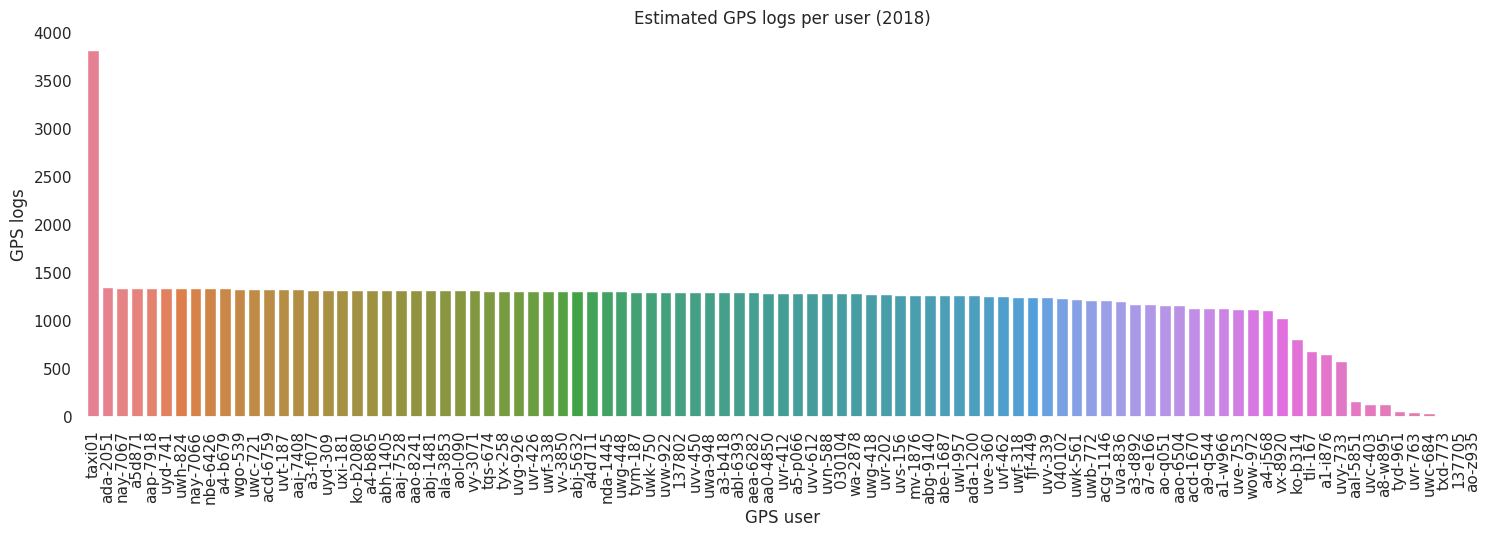

In [13]:
plt.figure(figsize=(18, 5))
fig = sns.barplot(data=gps_count_2019,
            y="count",
            x="id",
            hue="id")
fig.set_facecolor('white')
plt.xlabel("GPS user")
plt.ylabel("GPS logs")
plt.xticks(rotation=90)
plt.title("Estimated GPS logs per user (2018)")

# **Spacial Filtering**

To focus and limit our analysis, we will conduct a spatial filtering. This filter will constrain gps data within Metro Manila. This will exclude other areas adjacent to the capital.

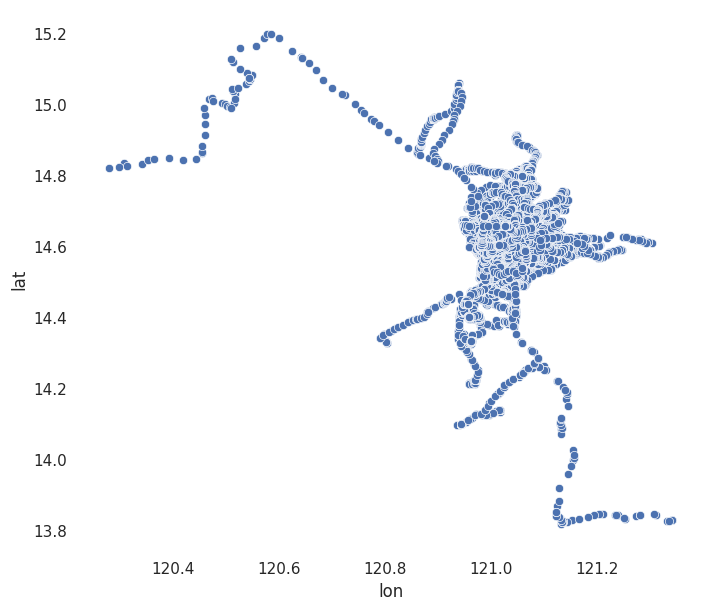

In [14]:
plt.figure(figsize=(8, 7))
fig = sns.scatterplot(data=gps_df_2018,
                x="lon",
                y="lat")
fig.set_facecolor('white')
plt.show()

In [15]:
# Spatial Filtering
gps_df_2018_norm = gps_df_2018.loc[(gps_df_2018["lon"]>=120.9) & (gps_df_2018["lon"]<=121.195)]
gps_df_2018_norm = gps_df_2018_norm.loc[(gps_df_2018_norm["lat"]>=14.35) & (gps_df_2018_norm["lat"]<=14.79)]

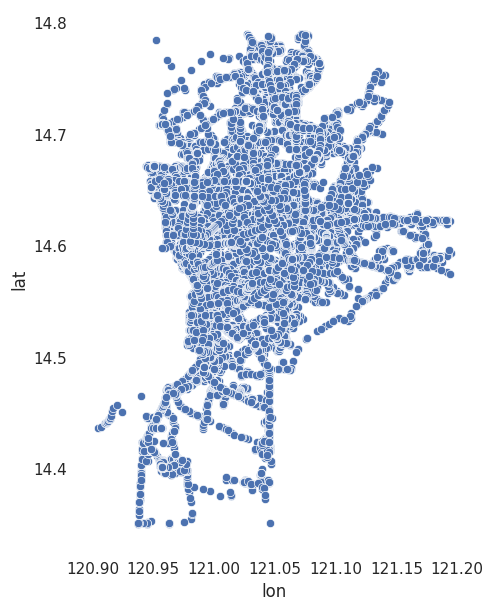

In [16]:
plt.figure(figsize=(5, 7))
fig = sns.scatterplot(data=gps_df_2018_norm,
                x="lon",
                y="lat")
fig.set_facecolor('white')
plt.show()

# **Exploratory Data Analysis**

In [17]:
## Aggregate count by day, hour and weekday
hourly_ride_data = gps_df_2018_norm.groupby(['day','hour','weekday'])["datetime"].count()
hourly_ride_data = hourly_ride_data.reset_index()
hourly_ride_data = hourly_ride_data.rename(columns = {'datetime':'ride_count'})
hourly_ride_data.head()

day  hour weekday  ride_count
0    4     7  Sunday         141
1    4     8  Sunday         382
2    4     9  Sunday         438
3    4    10  Sunday         428
4    4    11  Sunday         396

In [18]:
# Get the average rides from the ride count per weekday and hour.
hourly_avg = hourly_ride_data.groupby(["weekday", "hour",])['ride_count'].mean()
hourly_avg = hourly_avg.reset_index()
hourly_avg = hourly_avg.rename(columns={"ride_count":"avg_rides"})
hourly_avg.head()

weekday  hour  avg_rides
0  Friday     0      520.0
1  Friday     1      587.5
2  Friday     2      584.0
3  Friday     3      602.0
4  Friday     4      622.5

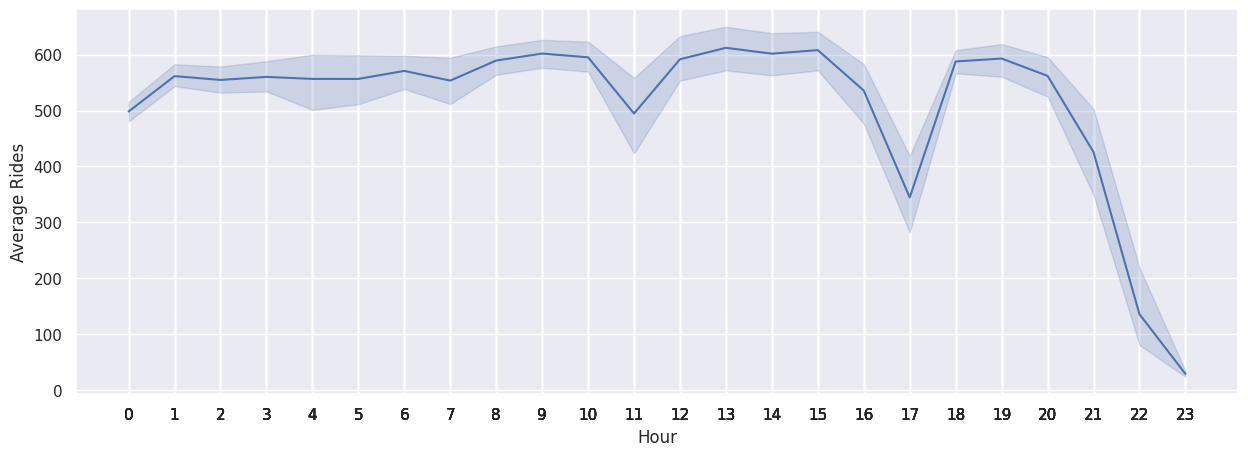

In [19]:
plt.figure(figsize=(15,5))

ax = sns.lineplot(x="hour",
             y="avg_rides",
             data=hourly_avg)
ax.set(xticks=hourly_avg.hour)
plt.xlabel("Hour")
plt.ylabel("Average Rides")
plt.show()

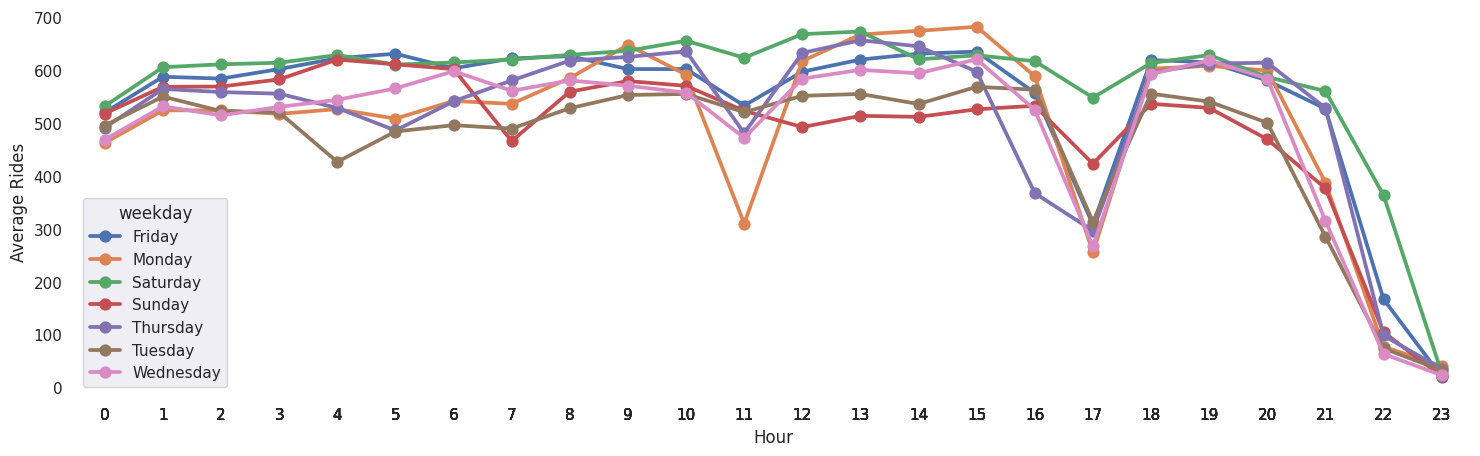

In [20]:
plt.figure(figsize=(18,5))

ax = sns.pointplot(x="hour",
             y="avg_rides",
             hue="weekday",
             data=hourly_avg)
ax.set(xticks=hourly_avg.hour)
ax.set_facecolor('white')
plt.xlabel("Hour")
plt.ylabel("Average Rides")
plt.show()

# **Stay Point Identification**

In [21]:
am_rush = gps_df_2018.loc[(gps_df_2018["hour"]==9)]      # 9 AM
noon_rush = gps_df_2018.loc[(gps_df_2018["hour"]==13)]   # 1 PM
pm_rush = gps_df_2018.loc[(gps_df_2018["hour"]==19)]     # 7 PM
am_rush.head()

id                       time        date        lat        lon  year  \
0  ko-b314  0 days 09:48:41.000000000  2018-03-08  14.588641  121.18521  2018   
1  ko-b314  0 days 09:50:41.000000000  2018-03-08  14.588641  121.18521  2018   
2  ko-b314  0 days 09:52:41.000000000  2018-03-08  14.588641  121.18521  2018   
3  ko-b314  0 days 09:54:41.000000000  2018-03-08  14.588641  121.18521  2018   
4  ko-b314  0 days 09:56:41.000000000  2018-03-08  14.588641  121.18521  2018   

   month  day  hour  minute  second            datetime   weekday  
0      3    8     9      48      41 2018-03-08 09:48:41  Thursday  
1      3    8     9      50      41 2018-03-08 09:50:41  Thursday  
2      3    8     9      52      41 2018-03-08 09:52:41  Thursday  
3      3    8     9      54      41 2018-03-08 09:54:41  Thursday  
4      3    8     9      56      41 2018-03-08 09:56:41  Thursday

In [22]:
# Restrict to Manila
manila_am_rush = am_rush.loc[(am_rush["lon"]>=120.9) & (am_rush["lon"]<=121.195)]
manila_am_rush = manila_am_rush.loc[(manila_am_rush["lat"]>=14.45) & (manila_am_rush["lat"]<=14.79)]

manila_noon_break = noon_rush.loc[(noon_rush["lon"]>=120.9) & (noon_rush["lon"]<=121.195)]
manila_noon_break = manila_noon_break.loc[(manila_noon_break["lat"]>=14.45) & (manila_noon_break["lat"]<=14.79)]

manila_pm_rush = pm_rush.loc[(pm_rush["lon"]>=120.9) & (pm_rush["lon"]<=121.195)]
manila_pm_rush = manila_pm_rush.loc[(manila_pm_rush["lat"]>=14.45) & (manila_pm_rush["lat"]<=14.79)]

In [23]:
class StayPoint_Identification():
  def __init__(self, data, cutoff_distance, minimum_time):
    self.gps_data = data
    self.cutoff_distance = cutoff_distance
    self.minimum_time = minimum_time
    self.staypoints = self.StayPoint()
    self.staypoints_df = self.to_dataframe()

  def Centroid(self, latitude, longitude):
    """
    This function computes the centroid of the
    collected coordinates inside the cut-off distance
    and exceeds the minimum time interval.

    input:
      latitude: list
      longitude: list
    output:
      centroid: float
    """
    if len(latitude)-1 == 0:
      centroid_latitude = sum(latitude)/(len(latitude))
      centroid_longitude = sum(longitude)/(len(longitude))
    else:
      centroid_latitude = sum(latitude)/(len(latitude)-1)
      centroid_longitude = sum(longitude)/(len(longitude)-1)

    # print("TEST CHECK 5 MEAN LOCATION: ", centroid_latitude, centroid_longitude)
    lat, lon = centroid_latitude, centroid_longitude
    return lat, lon

  def Radian(self, point):
    return float(point) * math.pi/180.0

  def Haversine_Distance(self, current_lat, current_lon, next_lat, next_lon):
    '''
    This function computes distance between two
    GPS points in km
    '''
    radius = 6371
    phi1 = self.Radian(current_lat)
    phi2 = self.Radian(next_lat)
    delta_phi = phi2 - phi1
    delta_lambda = self.Radian(next_lon) - self.Radian(current_lon)
    alpha = sin(delta_phi / 2) ** 2 + cos(phi1) * cos(phi2) * sin(delta_lambda/2) **2
    beta_distance = 2 * asin(sqrt(alpha))
    haversine_distance = radius * beta_distance
    return haversine_distance

  def StayPoint(self):
    """
    This function compress the data points by identifying
    if the coordinates agreed to the set parameters such as
    cutoff_distance and minimum_time.

    output: tuple-list
    """
    trajectories = self.gps_data[["datetime", "lat", "lon", "id"]].to_numpy()
    arrive_time = []
    leave_time = []
    center_latitude = []
    center_longitude = []
    user_id = []
    counts = []

    current_index = 0
    while current_index < trajectories.shape[0]:
      moving_index = current_index + 1
      lats_final, lons_final = [0], [0]
      while moving_index < trajectories.shape[0]:
        current_point = (trajectories[current_index][0],
                          trajectories[current_index][1],
                          trajectories[current_index][2],
                          trajectories[current_index][3])
        try:
          moving_point = (trajectories[moving_index][0],
                        trajectories[moving_index][1],
                        trajectories[moving_index][2],
                        trajectories[moving_index][3])
        except IndexError:
          pass

        # Compute Haversine Distance
        current_user = current_point[3]
        # lats, lons = [current_point[1]], [current_point[2]] # Initial points
        lats, lons = [], []
        threshold_distance = self.Haversine_Distance(current_point[1],
                                                     current_point[2],
                                                     moving_point[1],
                                                     moving_point[2])

        if threshold_distance <= self.cutoff_distance:
          # print(f"Threshold distance {threshold_distance} is inside the Cut-off Distance {self.cutoff_distance}.")
          initial_time = current_point[0]
          final_time = moving_point[0]
          time_interval = abs(final_time - initial_time)
          time_interval_s = time_interval / np.timedelta64(1, 's')
          # print(f"Initial time: {initial_time}, Next timestamp: {final_time}, ")
          # print(f"Computed time interval: {time_interval_s}.")
          if time_interval_s >= self.minimum_time:
              # print(f"{current_index} {moving_index} Time interval: {time_interval_s} exceeds the minimum time {self.minimum_time}.")
              # The present moving point will be added to the list.
              # print( "TEST CHECK 1",moving_point[1], moving_point[2])
              lats.append(moving_point[1])
              lons.append(moving_point[2])
              # print("TEST CHECK 2: ",lats, lons)
          lats_final.extend(lats)
          lons_final.extend(lons)
          # print("TEST CHECK 4: ", lats_final, lons_final)

          # Move to the next point.
          moving_index+=1
        elif threshold_distance >= self.cutoff_distance:
          # present moving point is outside the cut-off distance.
          # print("Adding of GPS points is terminated.")
          # print(f"Final time: {final_time}, Initial time: {initial_time}")
          break
        else:
          # Do nothing.
          pass

      # Compute mean coordinates

      # print("TEST CHECK 3", lats_final, lons_final)
      latitude_, longitude_ = self.Centroid(lats_final, lons_final)
      # print("check: ",len(lats))

      # Append Output lists
      # print(f"Final time: {final_time}, Initial time: {initial_time}")
      center_latitude.append(latitude_)
      center_longitude.append(longitude_)
      arrive_time.append(initial_time)
      leave_time.append(final_time)
      user_id.append(current_user)
      counts.append(int(len(lats_final)-1))

      # current index will move to the next moving index.
      current_index = moving_index

    return center_latitude, center_longitude, arrive_time, leave_time, user_id, counts

  def to_dataframe(self):
    """
    Converts the staypoint from tuple-list to dataframe.
    """
    latitude, longitude, arrive_time, leave_time, user_id, counts = self.staypoints
    # .T transposes the 4 by n array output of staypoints()
    gps_centers = pd.DataFrame([latitude, longitude, arrive_time, leave_time, user_id, counts]).T
    gps_centers.rename(columns={
        0: "latitude",
        1: "longitude",
        2: "arrive_time",
        3: "leave_time",
        4: "user_id",
        5: "cumulative_count"}, inplace=True)
    gps_centers = gps_centers.loc[gps_centers["longitude"] !=0]
    gps_centers["cumulative_time (s)"] = abs(gps_centers["leave_time"] - gps_centers["arrive_time"]) / np.timedelta64(1, 's')
    gps_centers["cumulative_count"] = gps_centers["cumulative_count"].astype(int)
    final_gps_centers = gps_centers[gps_centers["cumulative_time (s)"] >= self.minimum_time]
    return final_gps_centers

In [24]:
# This processing will take at least 5-6 mins in a stable connection.
# Process using distance = 5 Km and time interval = 600 seconds or 10 mins
am_staypoints = StayPoint_Identification(manila_am_rush, 4, 480)
am_centers = am_staypoints.staypoints_df
am_centers.head()

latitude   longitude         arrive_time          leave_time   user_id  \
0  14.589404  121.182429 2018-03-08 09:48:41 2018-03-09 09:22:01   ko-b314   
1  14.625282    121.1452 2018-03-09 09:27:38 2018-03-09 09:59:03   ko-b314   
2  14.588697  121.185218 2018-03-10 09:01:51 2018-03-19 09:57:58   ko-b314   
3   14.65713  121.105794 2018-03-04 09:01:57 2018-03-19 09:58:36   a4-j568   
4  14.672184  121.075519 2018-03-04 09:01:49 2018-03-04 09:59:32  aa0-4850   

   cumulative_count  cumulative_time (s)  
0                13              84800.0  
1                 8               1885.0  
2               282             780967.0  
3               469            1299399.0  
4                26               3463.0

Text(0.5, 1.0, 'GPS Stay Points (2018) Resulting Transformation  (9 AM)')

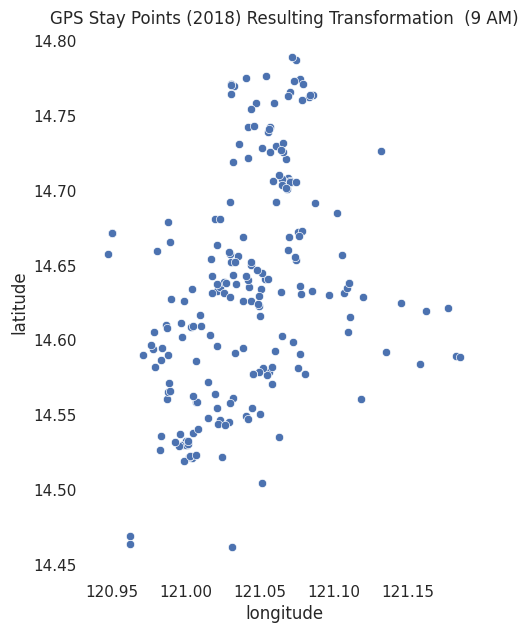

In [25]:
plt.figure(figsize=(5, 7))
ax = sns.scatterplot(am_centers,
            x="longitude",
            y="latitude")
ax.set_facecolor('white')
plt.title("GPS Stay Points (2018) Resulting Transformation  (9 AM)")

Text(0.5, 1.0, 'GPS Stay Points (2018) Resulting Transformation  (9 AM)')

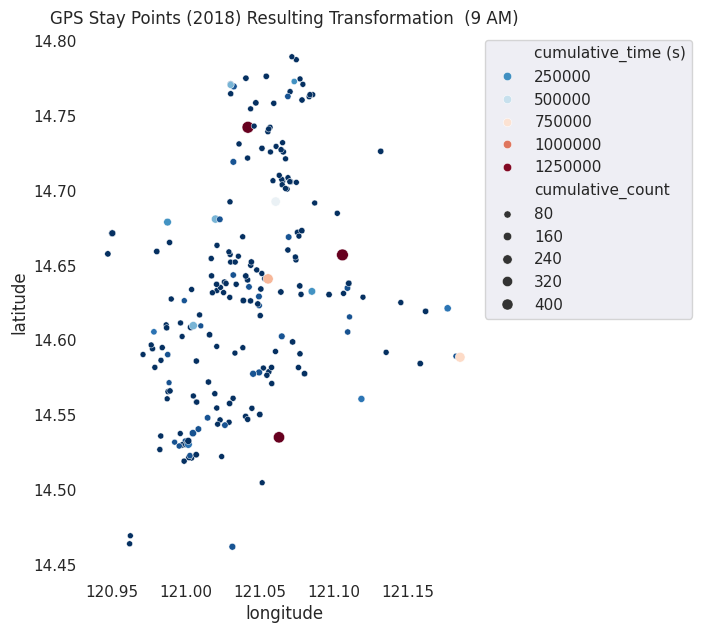

In [26]:
plt.figure(figsize=(5, 7))
ax = sns.scatterplot(am_centers,
            x="longitude",
            y="latitude",
            hue="cumulative_time (s)",
                     palette="RdBu_r",
                     size="cumulative_count")
ax.set_facecolor('white')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("GPS Stay Points (2018) Resulting Transformation  (9 AM)")

In [27]:
# This processing will take at least 5-6 mins in a stable connection.
noon_staypoints = StayPoint_Identification(manila_noon_break, 4, 480)
noon_centers = noon_staypoints.staypoints_df
noon_centers.head()

latitude   longitude         arrive_time          leave_time   user_id  \
0  14.588638  121.185168 2018-03-08 13:01:21 2018-03-19 13:58:09   ko-b314   
1  14.657243  121.105421 2018-03-05 13:01:19 2018-03-04 13:05:33   a4-j568   
2  14.666336  121.035363 2018-03-04 13:07:33 2018-03-04 13:17:33  aa0-4850   
3  14.678294  121.030883 2018-03-04 13:21:33 2018-03-04 13:59:19  aa0-4850   
4  14.705681  121.070755 2018-03-08 13:00:38 2018-03-08 13:26:38  aa0-4850   

   cumulative_count  cumulative_time (s)  
0               317             953808.0  
1               436              86146.0  
2                 1                600.0  
3                15               2266.0  
4                10               1560.0

Text(0.5, 1.0, 'GPS Stay Points (2018) Resulting Transformation  (1 PM)')

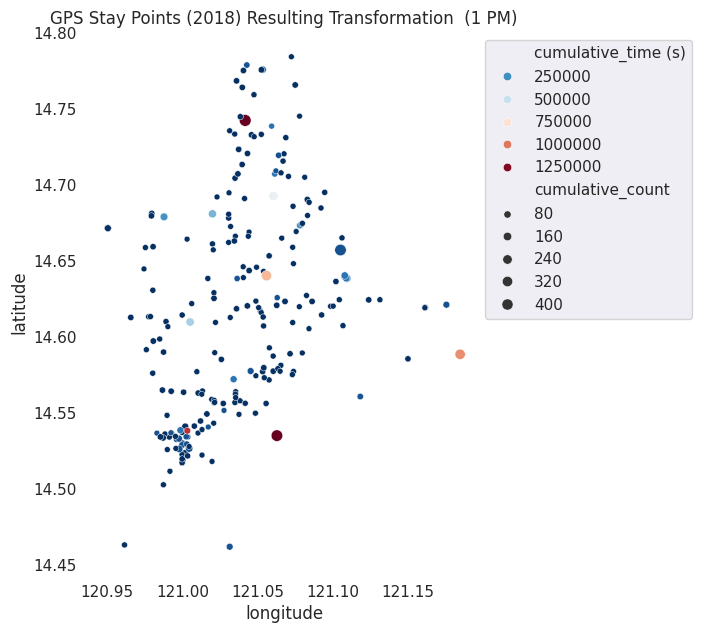

In [28]:
plt.figure(figsize=(5, 7))
ax = sns.scatterplot(noon_centers,
            x="longitude",
            y="latitude",
            hue="cumulative_time (s)",
            palette="RdBu_r",
            size="cumulative_count")
ax.set_facecolor('white')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("GPS Stay Points (2018) Resulting Transformation  (1 PM)")

In [29]:
# This processing will take at least 5-6 mins in a stable connection.
pm_staypoints = StayPoint_Identification(manila_pm_rush, 4, 480)
pm_centers = pm_staypoints.staypoints_df
pm_centers.head()

latitude   longitude         arrive_time          leave_time   user_id  \
0   14.58863  121.185296 2018-03-08 19:01:27 2018-03-19 19:58:55   ko-b314   
1  14.657099  121.105786 2018-03-04 19:00:04 2018-03-19 19:58:19   a4-j568   
2  14.594341  121.173348 2018-03-08 19:01:30 2018-03-08 19:57:30  aa0-4850   
3  14.673383  121.078389 2018-03-10 19:00:35 2018-03-10 19:58:35  aa0-4850   
4  14.557543  121.045238 2018-03-11 19:01:40 2018-03-11 19:39:40  aa0-4850   

   cumulative_count  cumulative_time (s)  
0               344             953848.0  
1               457            1299495.0  
2                23               3360.0  
3                26               3480.0  
4                11               2280.0

Text(0.5, 1.0, 'GPS Stay Points (2018) Resulting Transformation  (7 PM)')

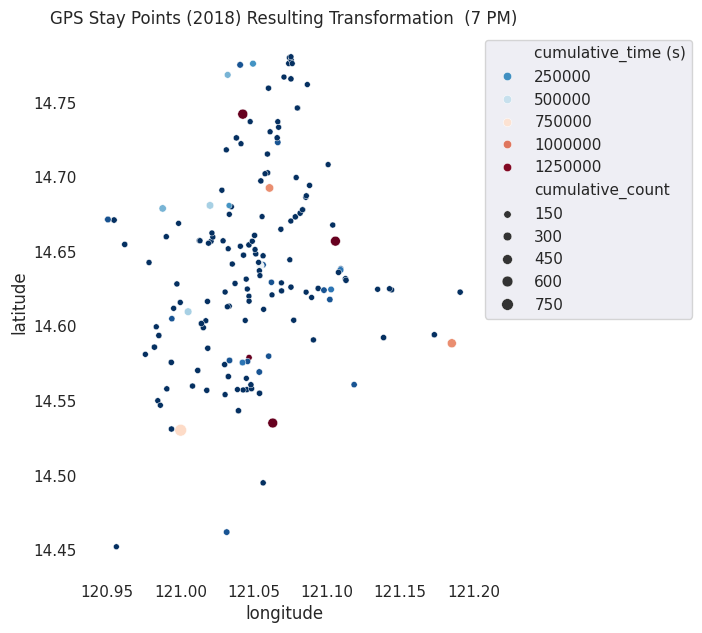

In [30]:
plt.figure(figsize=(5, 7))
ax = sns.scatterplot(pm_centers,
            x="longitude",
            y="latitude",
            hue="cumulative_time (s)",
            palette="RdBu_r",
            size="cumulative_count")
ax.set_facecolor('white')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("GPS Stay Points (2018) Resulting Transformation  (7 PM)")

# **Modeling**

### **I. K-Means Clustering**

In [31]:
# Cast the coordinates to float datatype
am_centers["latitude"] = am_centers["latitude"].astype(float)
am_centers["longitude"] = am_centers["longitude"].astype(float)
am_centers["cumulative_count_time_ratio"] = am_centers["cumulative_count"]/am_centers["cumulative_time (s)"]
am_centers["log_cumulative_time"] = np.log(am_centers["cumulative_time (s)"])

noon_centers["latitude"] = noon_centers["latitude"].astype(float)
noon_centers["longitude"] = noon_centers["longitude"].astype(float)
noon_centers["cumulative_count_time_ratio"] = noon_centers["cumulative_count"]/noon_centers["cumulative_time (s)"]
noon_centers["log_cumulative_time"] = np.log(noon_centers["cumulative_time (s)"])

pm_centers["latitude"] = pm_centers["latitude"].astype(float)
pm_centers["longitude"] = pm_centers["longitude"].astype(float)
pm_centers["cumulative_count_time_ratio"] = pm_centers["cumulative_count"]/pm_centers["cumulative_time (s)"]
pm_centers["log_cumulative_time"] = np.log(pm_centers["cumulative_time (s)"])

X_AM = am_centers[["cumulative_count", "log_cumulative_time", "cumulative_count_time_ratio"]].to_numpy()
X_NN = noon_centers[["cumulative_count", "log_cumulative_time", "cumulative_count_time_ratio"]].to_numpy()
X_PM = pm_centers[["cumulative_count", "log_cumulative_time", "cumulative_count_time_ratio"]].to_numpy()

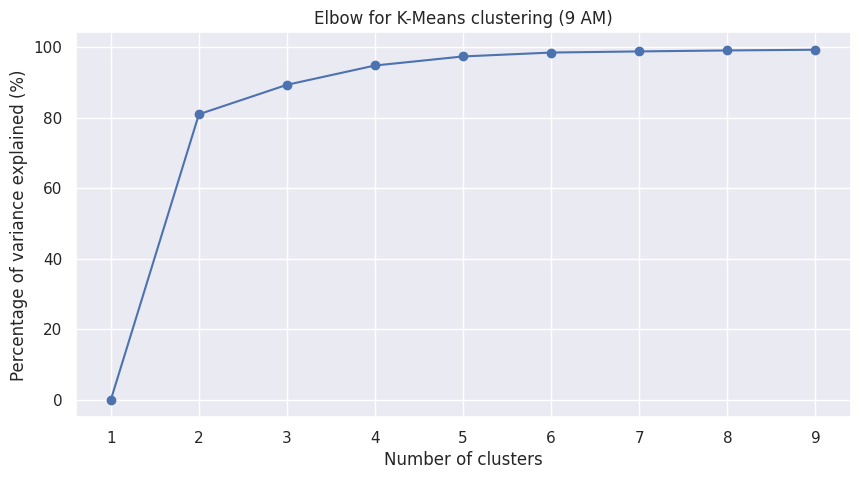

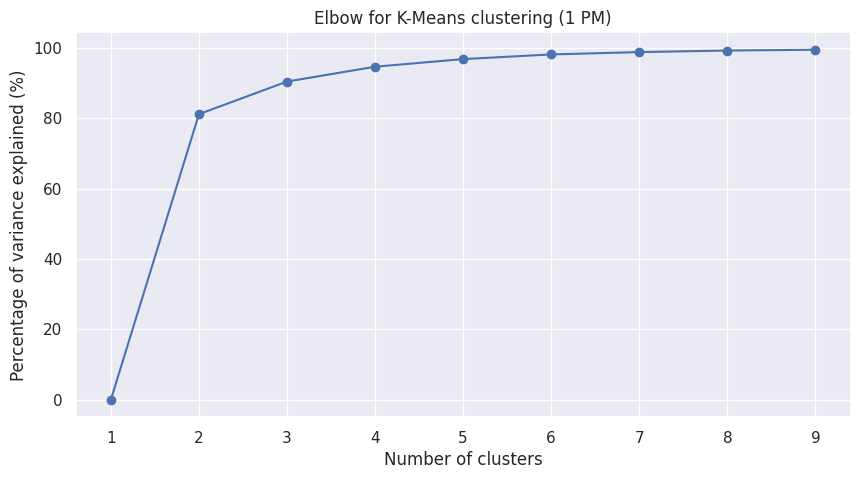

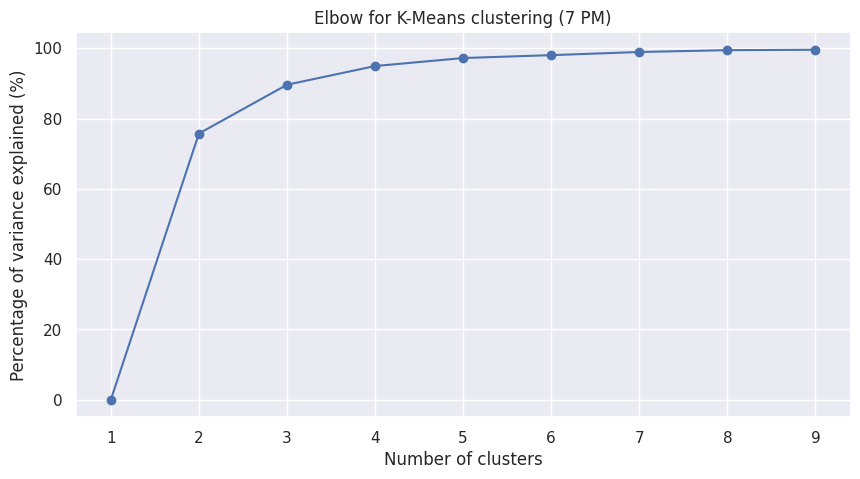

In [32]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
Ks = range(1, 10)


def plot_elbow(kmean, X, time_n):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'bo-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title(f'Elbow for K-Means clustering ({time_n})')
    plt.show()

subsets = [X_AM, X_NN, X_PM]
time_n = ["9 AM", "1 PM", "7 PM"]
for sets, ntime in zip(subsets, time_n):
  kmean = [KMeans(n_clusters=i, random_state=0).fit(sets) for i in Ks]
  plot_elbow(kmean, sets, ntime)

In [33]:
# Check shape
X_AM.shape

# Create a copy
morning_rush = am_centers.copy()

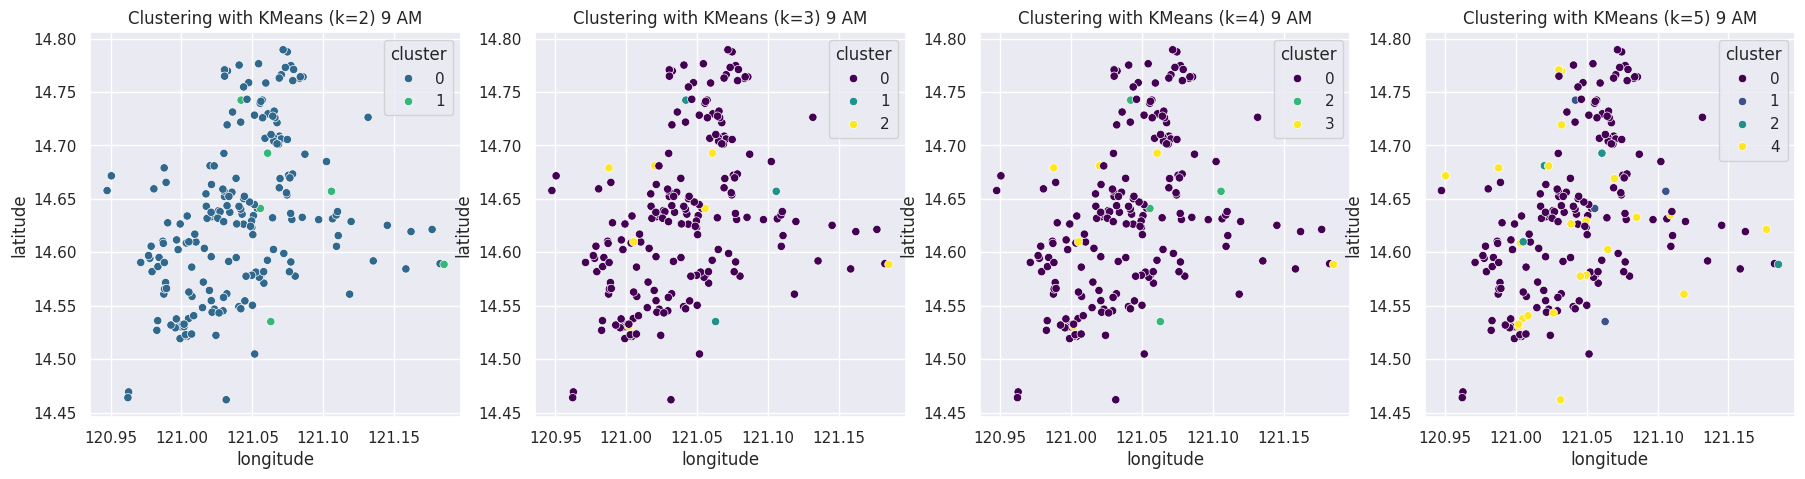

In [34]:
# Implement K-Means Clustering.
k = [2, 3, 4, 5] # 8 cluster to see the difference from optimum values.
n = len(k)
plt.subplots(nrows=1, ncols=4, figsize=(22,5))

for i in range(n):
    est = kmean[k[i]-1]
    morning_rush['cluster'] = est.predict(X_AM).tolist()
    ax = plt.subplot(1, 4, i+1)
    ax.set_title("Clustering with KMeans (k={}) 9 AM".format(k[i]))
    sns.scatterplot(data=morning_rush,
                    x="longitude", y="latitude",
                    hue="cluster",
                    palette="viridis")

We select cluster output no. 4.

In [40]:
# est = kmean[2]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_AM)
am_centers['cluster'] = kmeans.predict(X_AM).tolist()
fig = plt.figure(figsize=(6, 10))
ax.set_title("Spatial Clustering with KMeans (k={}) 9 AM".format(k[i]))
fig = px.scatter_mapbox(am_centers,
                        lat='latitude',
                        lon='longitude',
                        size="cumulative_count",
                        width=800,
                        height=800,
                        color="cluster",
                        color_continuous_scale ="bluered",
                        zoom=10.5).update_layout(mapbox_style="carto-positron")

fig.update_layout(title_text="Clustering of GPS Hotspots  (2018)")
fig.show()

<Figure size 600x1000 with 0 Axes>

In [41]:
# Let's visualize the stay points distribution of AM Rush hour
fig = px.scatter(am_centers,
                 x="cumulative_time (s)", y="cumulative_count",
                #  log_x=True,
                 log_y=True,
                 color="cluster",
                 size="cumulative_count",
                 height=600,
                 width=600,
                 color_continuous_scale="bluered",
                 template="simple_white")
fig.update_layout(title_text="Cluster Relationship in Time interval and GPS Counts <br><sup> Hotspots for Morning Rush (9AM) K = 3</sup>")
fig.show()

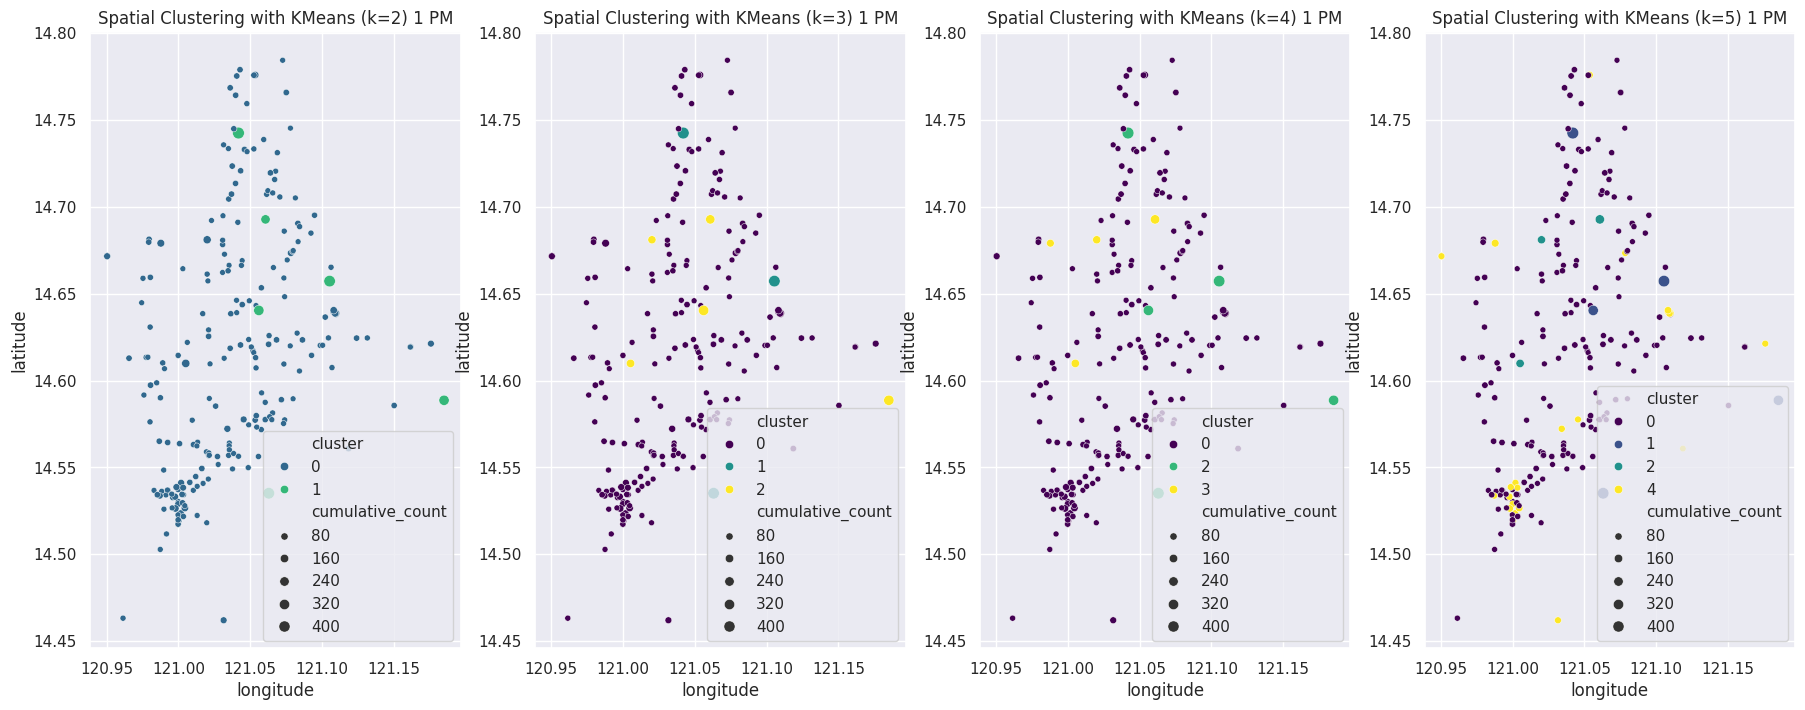

In [42]:
# Implement K-Means Clustering.
k = [2, 3, 4, 5] # 8 cluster to see the difference from optimum values.
n = len(k)
plt.subplots(nrows=1, ncols=4, figsize=(22,8))

for i in range(n):
    est = kmean[k[i]-1]
    noon_centers['cluster'] = est.predict(X_NN).tolist()
    ax = plt.subplot(1, 4, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={}) 1 PM".format(k[i]))
    sns.scatterplot(data=noon_centers,
                    x="longitude", y="latitude",
                    hue="cluster",
                    size="cumulative_count",
                    palette="viridis")

In [43]:
# Clustering Afternoon Rush
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_NN)
noon_centers['cluster'] = kmeans.predict(X_NN).tolist()
fig = plt.figure(figsize=(6, 10))
ax.set_title("Spatial Clustering with KMeans (k={}) 9 AM".format(k[i]))
fig = px.scatter_mapbox(noon_centers,
                        lat='latitude',
                        lon='longitude',
                        size="cumulative_count",
                        width=800,
                        height=800,
                        color="cluster",
                        color_continuous_scale ="bluered",
                        zoom=10.5).update_layout(mapbox_style="carto-positron")

fig.update_layout(title_text="Clustering of GPS Hotspots (2018)")
fig.show()

<Figure size 600x1000 with 0 Axes>

In [44]:
# Let's visualize the stay points distribution of AM Rush hour
fig = px.scatter(noon_centers,
                 x="cumulative_time (s)", y="cumulative_count",
                 color="cluster",
                 size="cumulative_count",
                 height=600,
                 width=600,
                 log_y=True,
                 color_continuous_scale="bluered",
                 template="simple_white")
fig.update_layout(title_text="Cluster Relationship in Time interval and GPS Counts <br><sup> Hotspots for Afternoon Rush Hour (1 PM)</sup>")
fig.show()

In [45]:
# Clustering of Night Rush Hour
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_PM)
pm_centers['cluster'] = kmeans.predict(X_PM).tolist()
fig = px.scatter_mapbox(pm_centers,
                        lat='latitude',
                        lon='longitude',
                        size="cumulative_count",
                        width=800,
                        height=800,
                        color="cluster",
                        color_continuous_scale ="bluered",
                        zoom=10.5).update_layout(mapbox_style="carto-positron")

fig.update_layout(title_text="Cluster Relationship in Time interval and GPS Counts <br><sup>Hotspots of Evening Rush Hour (7 PM)</sup>")
fig.show()

In [46]:
# Let's visualize the stay points distribution of AM Rush hour
fig = px.scatter(pm_centers,
                 x="cumulative_time (s)", y="cumulative_count",
                 color="cluster",
                 size="cumulative_count",
                 height=600,
                 width=600,
                 log_y=True,
                 color_continuous_scale="bluered",
                 template="simple_white")
fig.update_layout(title_text="Cluster Relationship in Time interval and GPS Counts <br><sup> Hotspots of Evening Rush Hour (7 PM)</sup>")
fig.show()

# **Modeling II**

In [47]:
# This processing will take at least 5-6 mins in a stable connection.
staypoints_2018 = StayPoint_Identification(gps_df_2018, 8, 480)
staypoints_2018 = staypoints_2018.staypoints_df
staypoints_2018.head()

latitude   longitude         arrive_time          leave_time   user_id  \
0  14.589011  121.184831 2018-03-08 09:48:41 2018-03-20 04:30:53   ko-b314   
1  14.657396  121.105263 2018-03-04 07:53:23 2018-03-04 13:17:33   a4-j568   
2  14.675209  121.049763 2018-03-04 13:21:33 2018-03-04 15:57:35  aa0-4850   
3  14.808919   121.05111 2018-03-04 16:02:06 2018-03-04 17:21:55  aa0-4850   
4  14.815986  121.054801 2018-03-04 17:24:06 2018-03-05 14:06:55  aa0-4850   

   cumulative_count  cumulative_time (s)  
0              6903            1017732.0  
1              9081              19450.0  
2                61               9362.0  
3                35               4789.0  
4               558              74569.0

In [48]:
print("Original Size: ", gps_df_2018.shape[0])
print("Compressed Size: ", staypoints_2018.shape[0])

Original Size:  217783
Compressed Size:  1449


In [50]:
staypoints_2018["cumulative_count_time_ratio"] = staypoints_2018["cumulative_count"]/staypoints_2018["cumulative_time (s)"]
X_staypoints = staypoints_2018[["cumulative_count", "cumulative_time (s)", "cumulative_count_time_ratio"]].to_numpy()

## **I. Hierarchical Clustering**

In [51]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

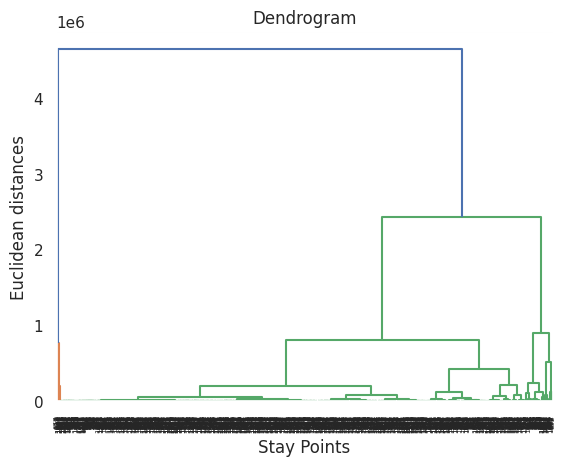

In [52]:
# Lets create a dendrogram variable linkage is actually the algorithm
# itself of hierarchical clustering and then in linkage we have to
# specify on which data we apply and engage. This is X dataset

dendrogram = sch.dendrogram(sch.linkage(X_staypoints, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Stay Points')
plt.ylabel('Euclidean distances')
plt.show()

In [53]:
aggve_model_2 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
aggve_model_4 = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')

staypoints_2018["hierarchical_cluster"] = aggve_model_4.fit_predict(X_staypoints)

In [54]:
fig = px.scatter_mapbox(staypoints_2018,
                        lat='latitude',
                        lon='longitude',
                        size="cumulative_time (s)",
                        width=800,
                        height=800,
                        color="hierarchical_cluster",
                        color_continuous_scale ="bluered",
                        zoom=10.5).update_layout(mapbox_style="carto-positron")

fig.update_layout(title_text="Clustering Stay Points <br><sup>Hotspots of Morning Rush Hour (9 AM)</sup>")
fig.show()

In [55]:
# Let's visualize the stay points distribution of AM Rush hour
fig = px.scatter(staypoints_2018[staypoints_2018["cumulative_count"]!=9081],
                 x="cumulative_time (s)", y="cumulative_count",
                 color="hierarchical_cluster",
                 size="cumulative_count",
                 height=400,
                 width=1100,
                 log_x=True,
                #  log_y=True,
                 color_continuous_scale="bluered",
                 template="simple_white")
fig.update_layout(title_text="Hierarchical Clustering  <br><sup>Relationship in Cumulative Time and Cumulative Count</sup>")
fig.show()

# **Optimal Value: Eps and Min Points**

In [59]:
# !pip install kneed

In [60]:
# from sklearn.neighbors import NearestNeighbors
# from kneed import KneeLocator
# nearest_neighbors = NearestNeighbors(n_neighbors=10) #
# neighbors = nearest_neighbors.fit(X_staypoints)
# distances, indices = neighbors.kneighbors(X_staypoints)
# distances = np.sort(distances[:,9], axis=0)

# fig = plt.figure(figsize=(8, 5))
# i = np.arange(len(distances))
# knee = KneeLocator(i, distances, S=1,
#                    curve='convex',
#                    direction='increasing',
#                    interp_method='polynomial')
# plt.figure(figsize=[10, 8])
# knee.plot_knee()

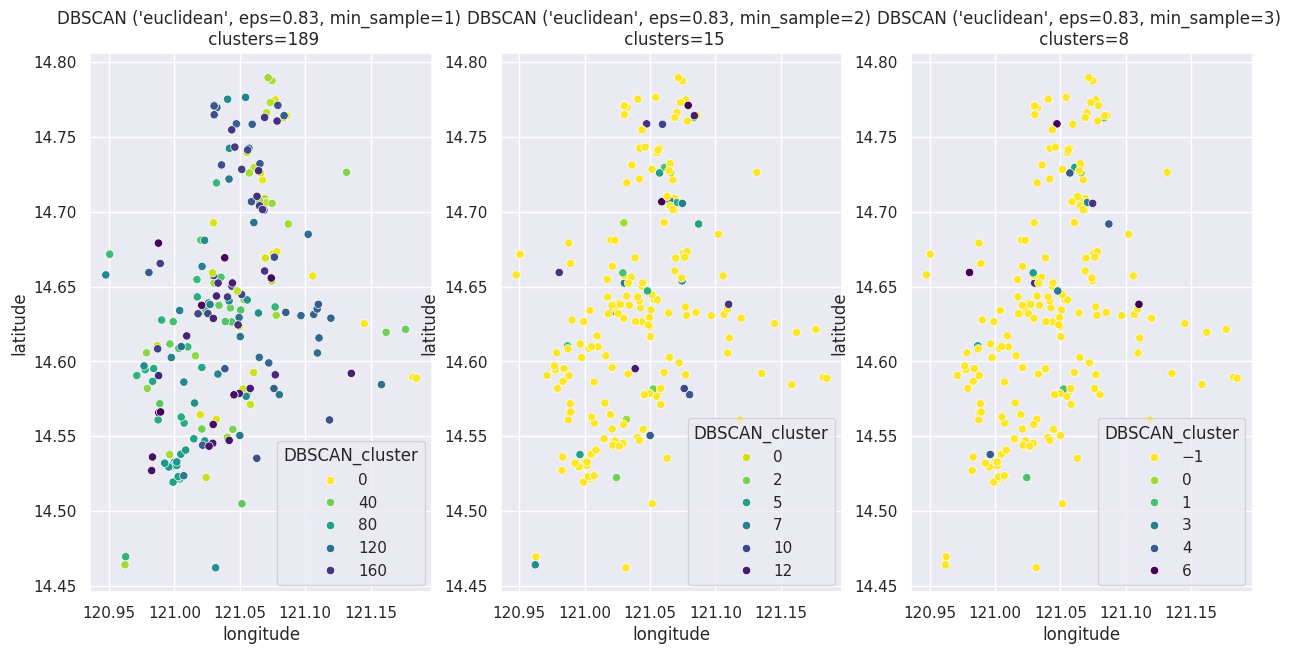

In [58]:
X = am_centers[["cumulative_count", "cumulative_time (s)", "cumulative_count_time_ratio", "log_cumulative_time", "cluster"]].to_numpy()
eps = [0.83]   # unit: latitude/longitude
min_sample = [1,2,3]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(15, 7))

for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        am_centers['DBSCAN_cluster'] = est.labels_.tolist()
        cluster_count = len(am_centers['DBSCAN_cluster'].unique())
        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title(f"DBSCAN ('euclidean', eps={eps[i]}, min_sample={min_sample[j]}) \n clusters={cluster_count}")
        sns.scatterplot(data=am_centers,
                    x="longitude", y="latitude",
                    hue="DBSCAN_cluster",
                    palette="viridis_r")

In [61]:
# Modeling DBSCAN
dbscan_model = DBSCAN(eps=2.3,
                      min_samples=4,
                      metric="euclidean").fit(X_staypoints)

staypoints_2018['DBSCAN_cluster'] = dbscan_model.labels_.tolist()
cluster_count = len(staypoints_2018['DBSCAN_cluster'].unique())
fig = px.scatter_mapbox(staypoints_2018[staypoints_2018["DBSCAN_cluster"]!=-1],
                        lat='latitude',
                        lon='longitude',
                        size="cumulative_count",
                        width=800,
                        height=800,
                        color="DBSCAN_cluster",
                        color_continuous_scale ="bluered",
                        zoom=10.5).update_layout(mapbox_style="carto-positron")

fig.update_layout(title_text="Cluster Relationship in Time interval and GPS Counts <br><sup>Hotspots of Morning Rush Hour (9 AM)</sup>")
fig.show()

In [62]:
# Let's visualize the stay points distribution of AM Rush hour
fig = px.scatter(staypoints_2018[staypoints_2018["DBSCAN_cluster"]!=-1],
                 x="cumulative_time (s)", y="cumulative_count",
                 color="DBSCAN_cluster",
                 size="cumulative_count",
                 height=600,
                 width=600,
                 log_y=True,
                 color_continuous_scale="bluered",
                 template="simple_white")
fig.update_layout(title_text="Cluster Relationship in Time interval and GPS Counts <br><sup> Hotspots of Evening Rush Hour (7 PM)</sup>")
fig.show()

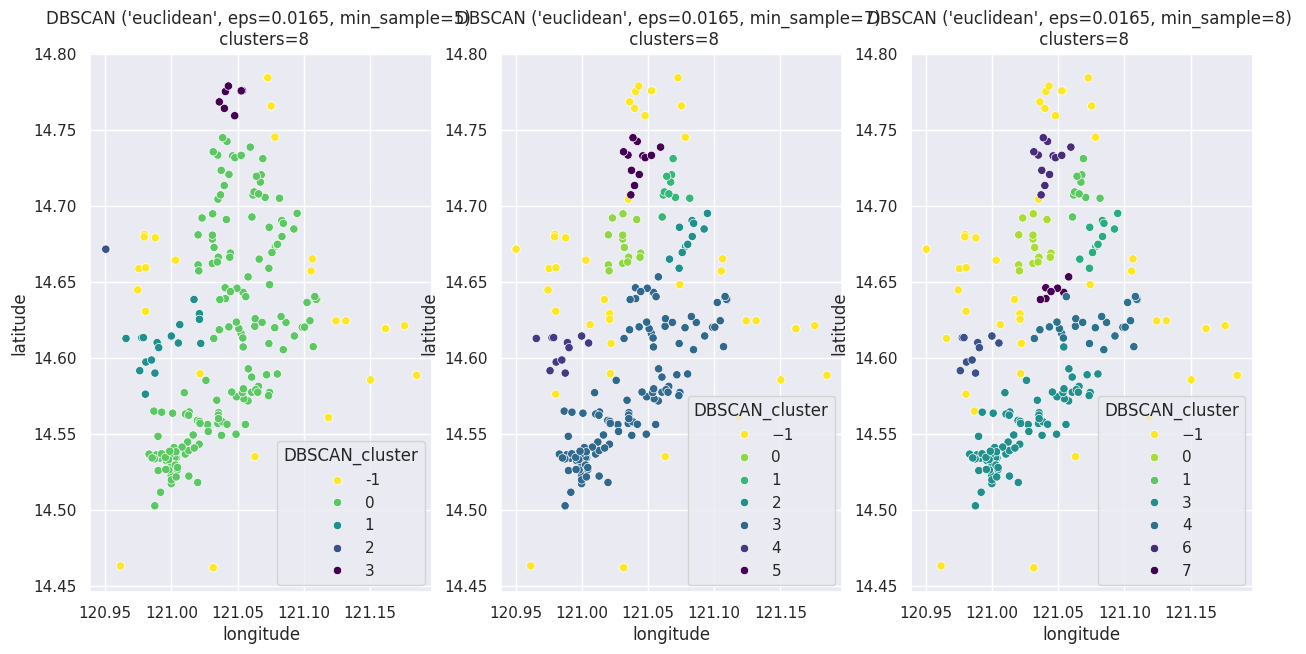

In [63]:
X = noon_centers[["longitude", "latitude"]].to_numpy()
eps = [0.0165]   # unit: latitude/longitude
min_sample = [5, 7, 8]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(15, 7))

for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        noon_centers['DBSCAN_cluster'] = est.labels_.tolist()
        cluster_count = len(am_centers['DBSCAN_cluster'].unique())
        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title(f"DBSCAN ('euclidean', eps={eps[i]}, min_sample={min_sample[j]}) \n clusters={cluster_count}")
        sns.scatterplot(data=noon_centers,
                    x="longitude", y="latitude",
                    hue="DBSCAN_cluster",
                    palette="viridis_r")

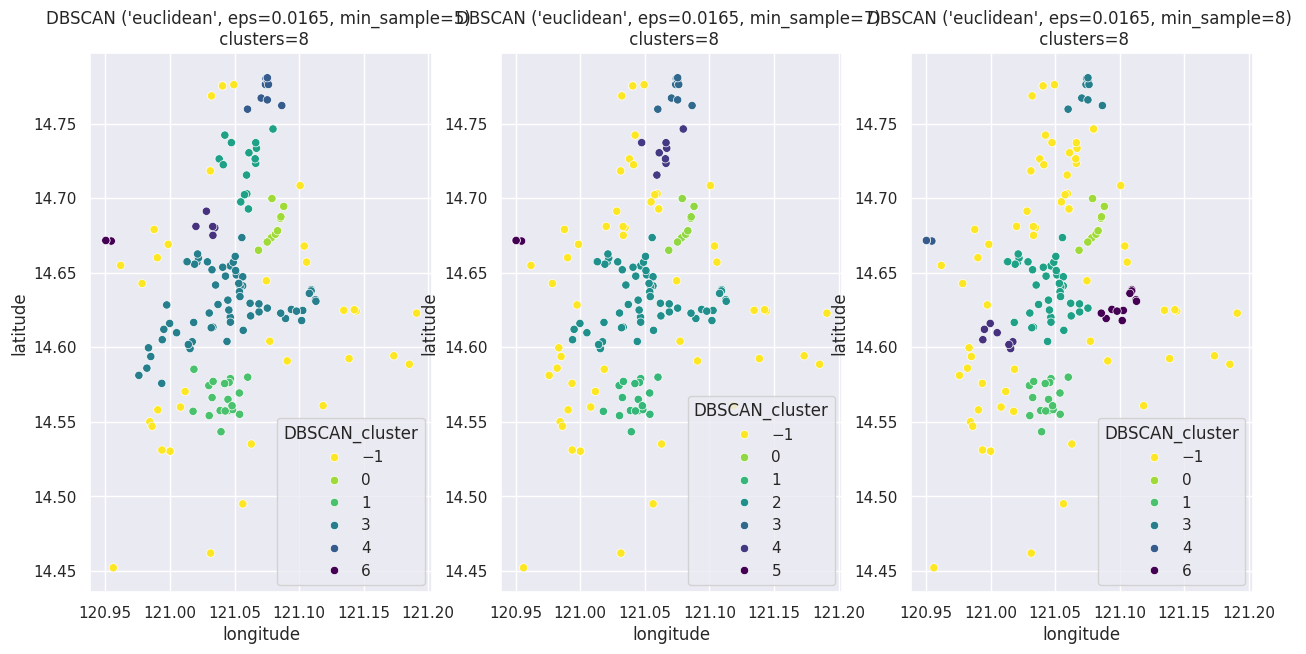

In [64]:
X = pm_centers[["longitude", "latitude"]].to_numpy()
eps = [0.0165]   # unit: latitude/longitude
min_sample = [5, 7, 8]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(15, 7))

for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        pm_centers['DBSCAN_cluster'] = est.labels_.tolist()
        cluster_count = len(am_centers['DBSCAN_cluster'].unique())
        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title(f"DBSCAN ('euclidean', eps={eps[i]}, min_sample={min_sample[j]}) \n clusters={cluster_count}")
        sns.scatterplot(data=pm_centers,
                    x="longitude", y="latitude",
                    hue="DBSCAN_cluster",
                    palette="viridis_r")